In [2]:
!pip install tensorflow==2.0.0b1

     |████████████████████████████████| 87.9MB 50kB/s 
     |████████████████████████████████| 501kB 43.1MB/s 
     |████████████████████████████████| 3.1MB 49.9MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!wget --no-check-certificate \
    https://drive.google.com/open?id=14_ZtEboEyMyBx2-4b9Bm7H05cbdeBRYN \
    -O /tmp/raw_data.csv

--2020-02-13 07:01:21--  https://drive.google.com/open?id=14_ZtEboEyMyBx2-4b9Bm7H05cbdeBRYN
Resolving drive.google.com (drive.google.com)... 108.177.120.139, 108.177.120.138, 108.177.120.101, ...
Connecting to drive.google.com (drive.google.com)|108.177.120.139|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://drive.google.com/file/d/14_ZtEboEyMyBx2-4b9Bm7H05cbdeBRYN/view?usp=drive_open [following]
--2020-02-13 07:01:21--  https://drive.google.com/file/d/14_ZtEboEyMyBx2-4b9Bm7H05cbdeBRYN/view?usp=drive_open
Reusing existing connection to drive.google.com:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/tmp/raw_data.csv’

/tmp/raw_data.csv       [ <=>                ]  67.40K  --.-KB/s    in 0.001s  

2020-02-13 07:01:21 (51.6 MB/s) - ‘/tmp/raw_data.csv’ saved [69019]



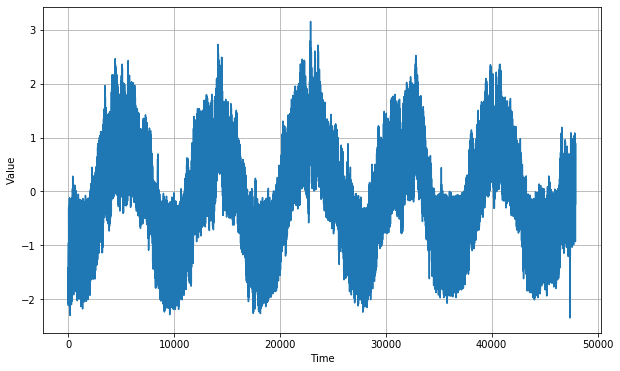

In [22]:
import csv
time_step = []
temps = []

with open('/tmp/data(1).csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  step=0
  for row in reader:
    temps.append(float(row[4]))
    time_step.append(step)
    step = step + 1

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = int(len(series)*0.99)
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [30]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(47448,)
Epoch 1/100
186/186 [==============================] - 75s 404ms/step - loss: 0.4144 - mae: 0.7916
Epoch 2/100
186/186 [==============================] - 73s 390ms/step - loss: 0.4144 - mae: 0.7916
Epoch 3/100
186/186 [==============================] - 70s 375ms/step - loss: 0.4143 - mae: 0.7915
Epoch 4/100
186/186 [==============================] - 69s 371ms/step - loss: 0.4143 - mae: 0.7914
Epoch 5/100
186/186 [==============================] - 70s 377ms/step - loss: 0.4142 - mae: 0.7913
Epoch 6/100
186/186 [==============================] - 70s 374ms/step - loss: 0.4141 - mae: 0.7912
Epoch 7/100
186/186 [==============================] - 70s 375ms/step - loss: 0.4141 - mae: 0.7911
Epoch 8/100
186/186 [==============================] - 71s 383ms/step - loss: 0.4140 - mae: 0.7910
Epoch 9/100
186/186 [==============================] - 72s 390ms/step - loss: 0.4138 - mae: 0.7909
Epoch 

[1e-08, 0.0001, 0, 0.5]

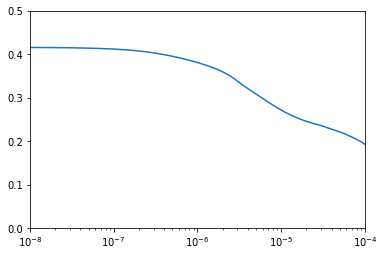

In [34]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 0.5])

In [35]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 4)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
474/474 [==============================] - 66s 139ms/step - loss: 0.3374 - mae: 0.7009
Epoch 2/150
474/474 [==============================] - 66s 139ms/step - loss: 0.2463 - mae: 0.5971
Epoch 3/150
474/474 [==============================] - 66s 139ms/step - loss: 0.2306 - mae: 0.5771
Epoch 4/150
474/474 [==============================] - 66s 139ms/step - loss: 0.2159 - mae: 0.5559
Epoch 5/150
474/474 [==============================] - 66s 138ms/step - loss: 0.1973 - mae: 0.5268
Epoch 6/150
474/474 [==============================] - 65s 138ms/step - loss: 0.1743 - mae: 0.4910
Epoch 7/150
474/474 [==============================] - 66s 139ms/step - loss: 0.1502 - mae: 0.4514
Epoch 8/150
474/474 [==============================] - 66s 140ms/step - loss: 0.1285 - mae: 0.4131
Epoch 9/150
474/474 [==============================] - 63s 133ms/step - loss: 0.1132 - mae: 0.3854
Epoch 10/150
474/474 [==============================] - 66s 138ms/step - loss: 0.1041 - mae: 0.3686
Epoch 11/

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 60)          360       
_________________________________________________________________
lstm (LSTM)                  (None, None, 60)          29040     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 60)          29040     
_________________________________________________________________
dense (Dense)                (None, None, 30)          1830      
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          310       
_________________________________________________________________
dense_2 (Dense)              (None, None, 1)           11        
_________________________________________________________________
lambda (Lambda)              (None, None, 1)           0

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

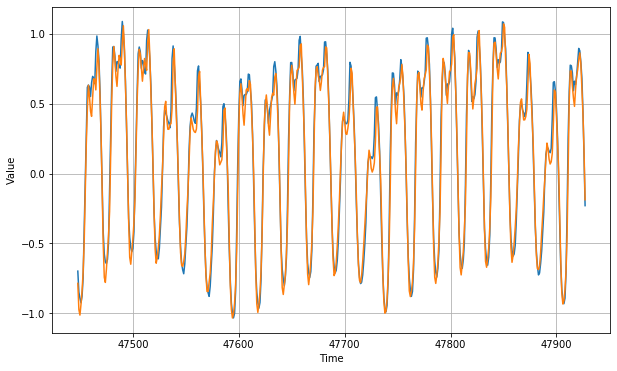

In [39]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [40]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.066686064

In [42]:
tf.keras.metrics.mean_absolute_percentage_error(x_valid, rnn_forecast).numpy()

20.746065

In [43]:
print(rnn_forecast[:20])

[-0.78571826 -0.9727602  -1.0127937  -0.93623435 -0.8423249  -0.7073857
 -0.49754268 -0.1261636   0.20890278  0.45708853  0.6311253   0.55331594
  0.44585425  0.4087121   0.5459214   0.67796725  0.6745848   0.5979163
  0.7605856   0.8926826 ]


In [45]:
print(x_valid[:20])

[-0.69832796 -0.84842171 -0.89125326 -0.92484552 -0.87824981 -0.74853302
 -0.3994685  -0.05063211  0.32409712  0.61670742  0.63270102  0.61933092
  0.55059838  0.64898792  0.69458149  0.67813163  0.64274692  0.87078806
  0.98357429  0.91398625]
